<a href="https://colab.research.google.com/github/gunelatakishyeva/DeepLearningProjects/blob/main/transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Rstam59/TaskDataRepoForStudents/main/helper_functions.py

--2024-08-05 15:15:37--  https://raw.githubusercontent.com/Rstam59/TaskDataRepoForStudents/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-08-05 15:15:37 (18.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys,walk_through_dir

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-08-05 15:15:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   166MB/s    in 17s     

2024-08-05 15:16:02 (88.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hummus'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caesar_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images

In [5]:
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode='categorical',
                                                                              image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE,
                                                              shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
checkpoint_path='101_classes_10_percent_data_model_checkpoint.weights.h5'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor='vall_accuracy',
                                                       save_best_only=True)

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation=Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
],name='data_augmentation')


In [8]:
base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=tf.keras.layers.Input(shape=(224,224,3),name='input_shape')
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax',name='output_layer')(x)
model=tf.keras.Model(inputs,outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_shape (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])
history=model.fit(train_data_all_10_percent,epochs=5,batch_size=32,
                  steps_per_epoch=len(train_data_all_10_percent),
                  validation_data=test_data,
                  validation_steps=int(0.15*len(test_data)),
                  callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 61s 193ms/step - accuracy: 0.1311 - loss: 4.0554 - val_accuracy: 0.3946 - val_loss: 2.7637
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with vall_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


237/237 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3919 - val_loss: 2.6627
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.4152 - loss: 2.5997 - val_accuracy: 0.5260 - val_loss: 1.9769
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5156 - val_loss: 2.1006
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.4894 - loss: 2.1868 - val_accuracy: 0.5328 - val_loss: 1.9137


In [11]:
result_feature_extraction_model=model.evaluate(test_data)
result_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.4970 - loss: 2.0421


[1.9614014625549316, 0.5110890865325928]

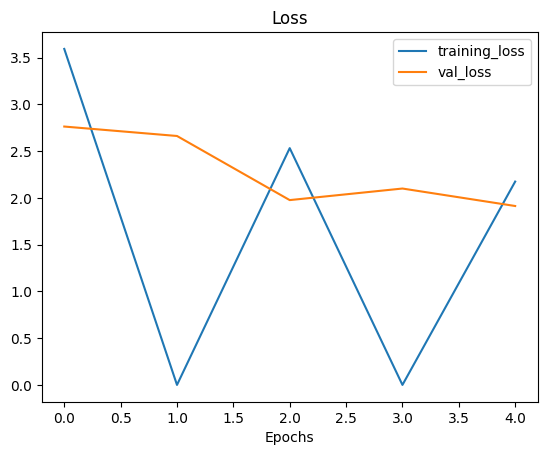

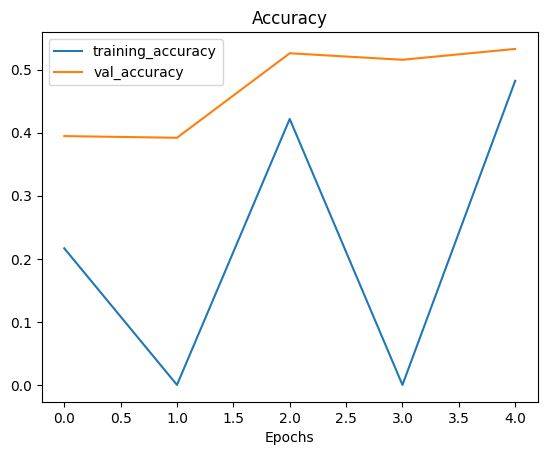

In [12]:
plot_loss_curves(history)

In [13]:
base_model.trainable=False
for layer in base_model.layers[-5:]:
  layer.trainable=True

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [15]:
for layer in model.layers:
  print(layer.name,layer.trainable)

input_shape True
data_augmentation True
efficientnetb0 False
global_average_pooling True
output_layer True


In [16]:
for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [17]:
fine_tune_epochs=10

history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - accuracy: 0.5207 - loss: 2.0553 - val_accuracy: 0.4817 - val_loss: 2.0586
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 174ms/step - accuracy: 0.5679 - loss: 1.8270 - val_accuracy: 0.5355 - val_loss: 1.7940
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.5887 - loss: 1.6935 - val_accuracy: 0.5927 - val_loss: 1.6002
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.6062 - loss: 1.6222 - val_accuracy: 0.5649 - val_loss: 1.6632
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.6152 - loss: 1.5525 - val_accuracy: 0.6197 - val_loss: 1.4893
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.6365 - loss: 1.4732 - val_accuracy: 0.5948 - val_loss: 1.4857


In [18]:
results_all_classes_10_percent_fine_tune=model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5469 - loss: 1.7353


[1.6269131898880005, 0.5716039538383484]

In [ ]:
compare_historys(original_history=history,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

#Make predictions with our trained model

In [20]:
pred_probs=model.predict(test_data,verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step


In [23]:
pred_classes=pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29, 46, 85,  0])

In [21]:
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
len(y_labels)

25250

In [24]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If None, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

In [25]:
class_names=test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [27]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,pred_classes))

              precision    recall  f1-score   support

           0       0.26      0.14      0.18       250
           1       0.41      0.74      0.53       250
           2       0.63      0.57      0.60       250
           3       0.76      0.46      0.58       250
           4       0.52      0.42      0.46       250
           5       0.39      0.37      0.38       250
           6       0.77      0.70      0.73       250
           7       0.83      0.68      0.75       250
           8       0.25      0.46      0.32       250
           9       0.40      0.59      0.47       250
          10       0.47      0.40      0.43       250
          11       0.68      0.56      0.62       250
          12       0.73      0.52      0.61       250
          13       0.48      0.57      0.52       250
          14       0.50      0.55      0.52       250
          15       0.35      0.33      0.34       250
          16       0.63      0.50      0.56       250
          17       0.39    

In [29]:
classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'precision': 0.25735294117647056,
  'recall': 0.14,
  'f1-score': 0.18134715025906734,
  'support': 250.0},
 '1': {'precision': 0.4144144144144144,
  'recall': 0.736,
  'f1-score': 0.5302593659942363,
  'support': 250.0},
 '2': {'precision': 0.6299559471365639,
  'recall': 0.572,
  'f1-score': 0.59958071278826,
  'support': 250.0},
 '3': {'precision': 0.7581699346405228,
  'recall': 0.464,
  'f1-score': 0.575682382133995,
  'support': 250.0},
 '4': {'precision': 0.5198019801980198,
  'recall': 0.42,
  'f1-score': 0.4646017699115044,
  'support': 250.0},
 '5': {'precision': 0.3924050632911392,
  'recall': 0.372,
  'f1-score': 0.38193018480492813,
  'support': 250.0},
 '6': {'precision': 0.7665198237885462,
  'recall': 0.696,
  'f1-score': 0.7295597484276729,
  'support': 250.0},
 '7': {'precision': 0.8300970873786407,
  'recall': 0.684,
  'f1-score': 0.75,
  'support': 250.0},
 '8': {'precision': 0.2452431289640592,
  'recall': 0.464,
  'f1-score': 0.3208852005532503,
  'support'

In [37]:
class_f1_scores={}
for k,v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]]=v['f1-score']
class_f1_scores

{'apple_pie': 0.18134715025906734,
 'baby_back_ribs': 0.5302593659942363,
 'baklava': 0.59958071278826,
 'beef_carpaccio': 0.575682382133995,
 'beef_tartare': 0.4646017699115044,
 'beet_salad': 0.38193018480492813,
 'beignets': 0.7295597484276729,
 'bibimbap': 0.75,
 'bread_pudding': 0.3208852005532503,
 'breakfast_burrito': 0.47266881028938906,
 'bruschetta': 0.43043478260869567,
 'caesar_salad': 0.6157205240174671,
 'cannoli': 0.6074766355140186,
 'caprese_salad': 0.5230202578268877,
 'carrot_cake': 0.5227272727272728,
 'ceviche': 0.34024896265560167,
 'cheese_plate': 0.56,
 'cheesecake': 0.4272890484739677,
 'chicken_curry': 0.39999999999999997,
 'chicken_quesadilla': 0.6119733924611974,
 'chicken_wings': 0.652991452991453,
 'chocolate_cake': 0.5294117647058824,
 'chocolate_mousse': 0.33649289099526064,
 'churros': 0.728813559322034,
 'clam_chowder': 0.7212475633528265,
 'club_sandwich': 0.6356877323420074,
 'crab_cakes': 0.4079207920792079,
 'creme_brulee': 0.7306122448979593,
 'cr

In [39]:
import pandas as pd
f1_scores=pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
print(f1_scores.head())

   class_name  f1-score
33    edamame  0.968379
63   macarons  0.836364
75        pho  0.833333
86    sashimi  0.816956
64  miso_soup  0.808511


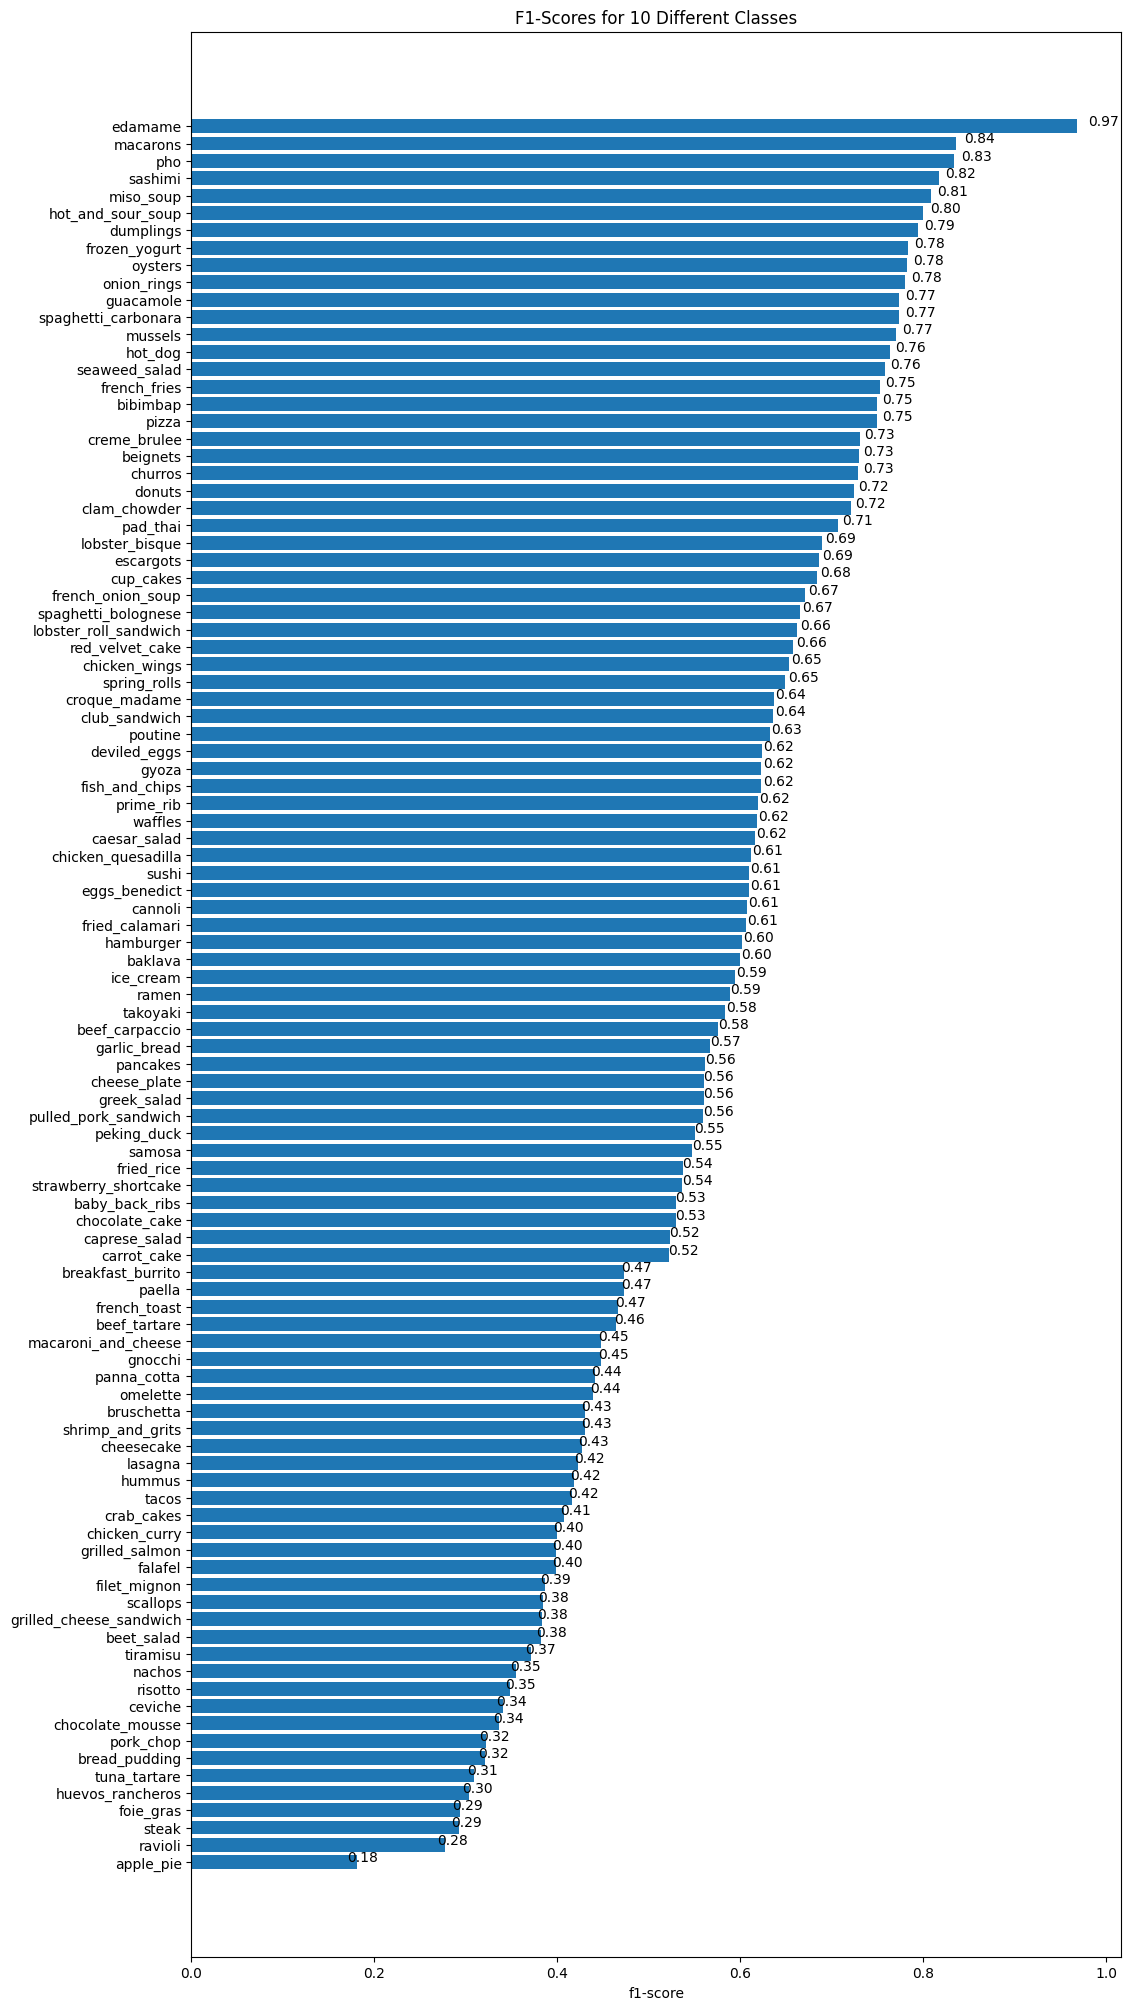

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [44]:
def load_and_prep_image(filename,img_shape=224,scale=True):

  img=tf.io.read_file(filename)
  img=tf.io.decode_image(img)
  img=tf.image.resize(img,[img_shape,img_shape])
  if scale:
    return img/255.
  else:
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


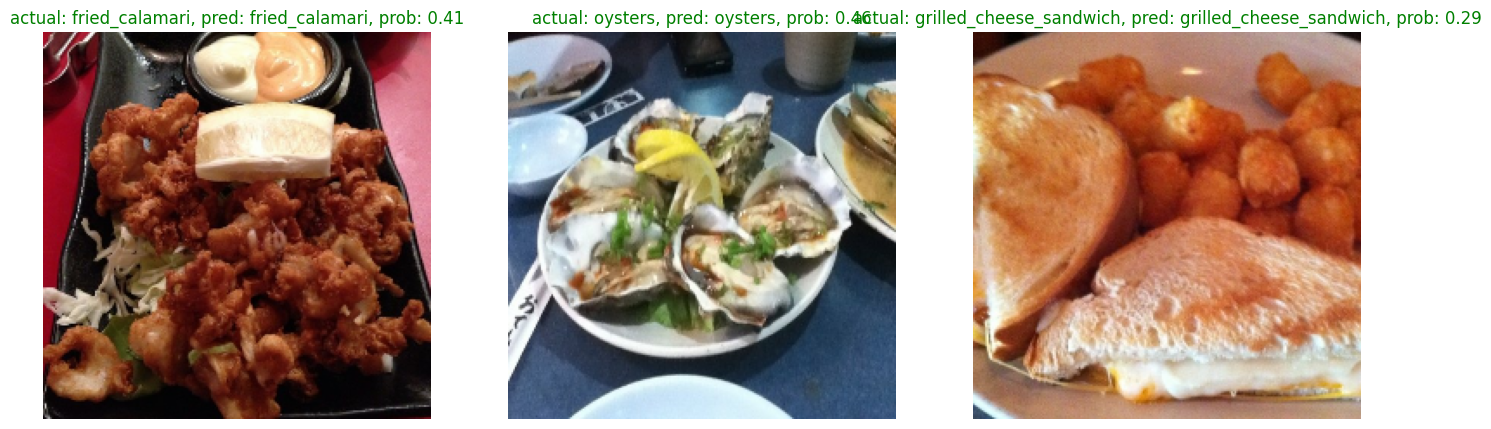

In [45]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [48]:
filepaths=[]
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg',
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [49]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0       0   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      38   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.349566        apple_pie        apple_pie  
1   0.850468        apple_pie        apple_pie  
2   0.258622        apple_pie        apple_pie  
3   0.258020        apple_pie   fish_and_chips  
4   0.380528        apple_pie    bread_pudding

In [50]:
pred_df['pred_correct']=pred_df['y_true']==pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0       0   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      38   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.349566        apple_pie        apple_pie          True  
1   0.850468        apple_pie        apple_pie          True  
2   0.258622        apple_pie        apple_pie          True  
3   0.258020        apple_pie   fish_and_chips         False  
4   0.380528        apple_pie    bread_pudding         False

In [51]:
top_100_wrong=pred_df[pred_df['pred_correct']==False].sort_values('pred_conf',ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
22     b'/content/101_food_classes_10_percent/test/ap...       0     100   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
11097  b'/content/101_food_classes_10_percent/test/fr...      44      70   
10947  b'/content/101_food_classes_10_percent/test/fr...      43      68   
13094  b'/content/101_food_classes_10_percent/test/gy...      52      32   
22606  b'/content/101_food_classes_10_percent/test/sp...      90       1   
17816  b'/content/101_food_classes_10_percent/test/pa...      71      70   
22511  b'/content/101_food_classes_10_percent/test/sp...      90      78   
15826  b'/content/101_food_classes_10_percent/test/ma...      63      29   
9073   b'/content/101_food_classes_10_percent/test/fa...      36      26   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
14062  b'/content/101_food_classes_10_percent/test/hu...      56      28   
21216  b'/content/101_food_classes_10_percent/test/ri...      84      70   
12487  b'/content/101_food_classes_10_percent/test/gr...      49      25   
10289  b'/content/101_food_classes_10_percent/test/fr...      41      62   
18510  b'/content/101_food_classes_10_percent/test/pe...      74       1   
19374  b'/content/101_food_classes_10_percent/test/po...      77       1   

       pred_conf         y_true_classname     y_pred_classname  pred_correct  
10847   0.997680           fried_calamari          onion_rings         False  
23631   0.996072     strawberry_shortcake      red_velvet_cake         False  
22      0.990848                apple_pie              waffles         False  
23797   0.990506                    sushi              sashimi         False  
15359   0.989884    lobster_roll_sandwich            hamburger         False  
11097   0.989806               fried_rice             pad_thai         False  
10947   0.989641           fried_calamari          onion_rings         False  
13094   0.983859                    gyoza            dumplings         False  
22606   0.983832      spaghetti_bolognese       baby_back_ribs         False  
17816   0.982105                   paella             pad_thai         False  
22511   0.981479      spaghetti_bolognese              poutine         False  
15826   0.979538                 macarons            cup_cakes         False  
9073    0.979362                  falafel           crab_cakes         False  
10854   0.978954           fried_calamari          onion_rings         False  
14062   0.978445         huevos_rancheros        croque_madame         False  
21216   0.977735                  risotto             pad_thai         False  
12487   0.976232  grilled_cheese_sandwich        club_sandwich         False  
10289   0.970430        french_onion_soup  macaroni_and_cheese         False  
18510   0.967854              peking_duck       baby_back_ribs         False  
19374   0.967627                pork_chop       baby_back_ribs         False